In [1]:
!nvidia-smi

Wed Dec 11 06:10:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:40:00.0 Off |                    0 |
| N/A   57C    P0            459W /  400W |   52803MiB /  81920MiB |     83%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [3]:
# Verify the GPU is working, and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
!ls

Original_Model.ipynb  modelep2.pth  modelep8.pth
README.md	      modelep3.pth  testing.ipynb
Untitled1.ipynb       modelep4.pth  training_data.csv
model2		      modelep5.pth  training_data_january_2023.csv
modelep0.pth	      modelep6.pth  untitled.txt
modelep1.pth	      modelep7.pth


In [5]:
# Either Load the data from the pickle
# df = pd.read_pickle('training_data.pkl')
# Or load the data from the csv
df = pd.read_csv('training_data.csv', names=['timestamp', 'Station', 'Total_Flow'])

# Convert 'timestamp' to datetime and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.dropna(inplace=True)

# Initialize and apply the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['traffic_flow_scaled'] = scaler.fit_transform(df[['Total_Flow']])

In [6]:
# Define input and forecast lengths
input_length = 192   # 48 hours * 4 intervals/hour = 192 steps
forecast_length = 96  # 24 hours * 4 intervals/hour = 96 steps

# Create sequences for multi-step forecasting
def create_sequences(data, input_length, forecast_length):
    xs, ys = [], []
    for i in range(len(data) - input_length - forecast_length + 1):
        x = data[i : i + input_length]
        y = data[i + input_length : i + input_length + forecast_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(df['traffic_flow_scaled'].values, input_length, forecast_length)

# Split data into training and testing sets
train_size = int(X.shape[0] * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [7]:
# Custom Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float), torch.tensor(self.y[idx], dtype=torch.float)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

In [8]:
# Define the LSTM model
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size=1, hidden_size=256, output_size=96, num_layers=4):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers=self.num_layers, dropout=0.2, bidirectional=True)
        self.fc = torch.nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        h_0 = torch.zeros(2 * self.num_layers, x.size(1), self.hidden_size, device=x.device)
        c_0 = torch.zeros(2 * self.num_layers, x.size(1), self.hidden_size, device=x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        last_out = out[-1, :, :]
        predictions = self.fc(last_out)
        return predictions

model = LSTMModel().to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Evaluating model
Evaluating model
Evaluating model
MSE for model epoch 4: 18680.58008
MSE for model epoch 7: 17165.31445
MSE for model epoch 8: 16829.72461


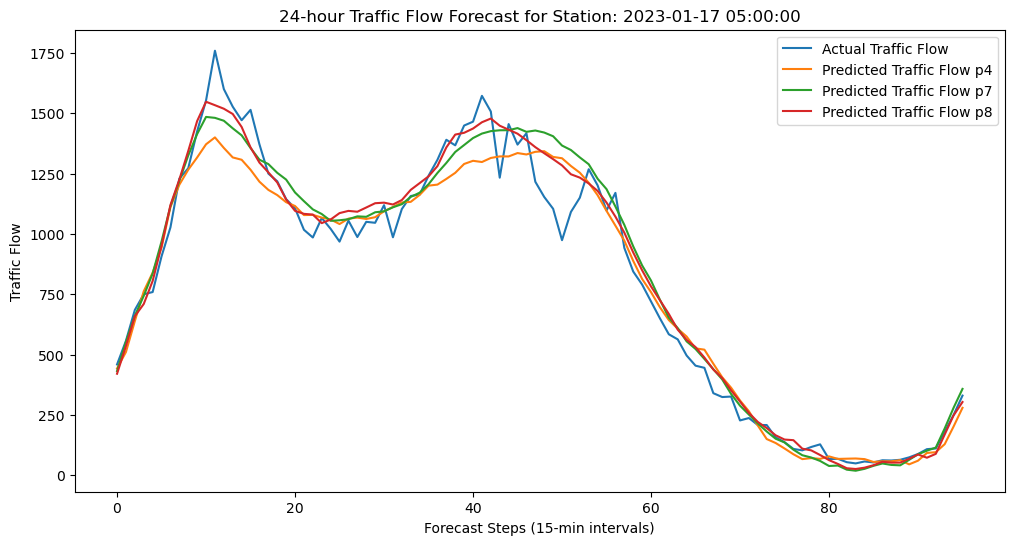

In [9]:
from sklearn.metrics import mean_squared_error

model = LSTMModel(input_size=1, hidden_size=256, output_size=96, num_layers=4).to(device)

# Helper function to load model/make predictions/calc mse
def evaluate_model(model_path, test_loader):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    predictions = []
    actuals = []

    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            sequences = sequences.unsqueeze(2).permute(1, 0, 2)
            # Make predictions
            outs = model(sequences)
            predictions.append(outs.cpu().numpy())
            actuals.append(targets.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    predictions = scaler.inverse_transform(predictions)
    actuals = scaler.inverse_transform(actuals)

    mse = mean_squared_error(actuals.flatten(), predictions.flatten())
    return predictions, actuals, mse

print("Evaluating model")
predictionsp4, actuals, mse_p4 = evaluate_model('modelep4.pth', test_loader)
print("Evaluating model")
predictionsp7, _, mse_p7 = evaluate_model('modelep7.pth', test_loader)
print("Evaluating model")
predictionsp8, _, mse_p8 = evaluate_model('modelep8.pth', test_loader)
#predictionsp9, _, mse_p9 = evaluate_model('modelep9.pth', test_loader)
#predictionsp10, _, mse_p10 = evaluate_model('modelep10.pth', test_loader)
# Print MSE for each model
print(f'MSE for model epoch 4: {mse_p4:.5f}')
print(f'MSE for model epoch 7: {mse_p7:.5f}')
print(f'MSE for model epoch 8: {mse_p8:.5f}')
#print(f'MSE for model epoch 9: {mse_p9:.5f}')
#print(f'MSE for model epoch 10: {mse_p10:.5f}')
# Extract the station ID for the specific example

station_id = df['Station'].iloc[train_size]
# Visualize one example forecast with station information
plt.figure(figsize=(12, 6))
plt.plot(actuals[0], label='Actual Traffic Flow')
plt.plot(predictionsp4[0], label='Predicted Traffic Flow p4')
plt.plot(predictionsp7[0], label='Predicted Traffic Flow p7')
plt.plot(predictionsp8[0], label='Predicted Traffic Flow p8')
#plt.plot(predictionsp9[0], label='Predicted Traffic Flow p9')
#plt.plot(predictionsp10[0], label='Predicted Traffic Flow p10')
plt.xlabel('Forecast Steps (15-min intervals)')
plt.ylabel('Traffic Flow')
plt.title(f'24-hour Traffic Flow Forecast for Station: {station_id}')

plt.legend()
plt.show()

MSE for model epoch 9: 18770.46875


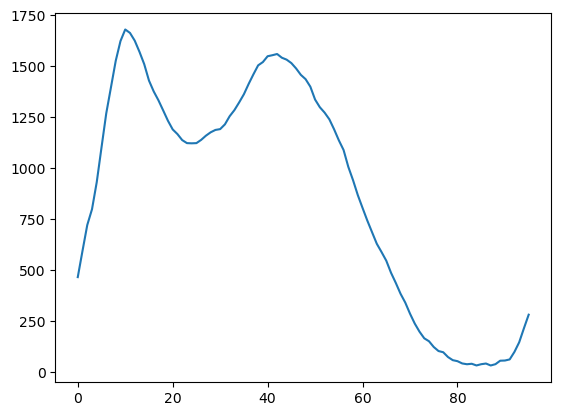

In [10]:
predictionsp9, _, mse_p9 = evaluate_model('modelep9.pth', test_loader)
print(f'MSE for model epoch 9: {mse_p9:.5f}')
plt.plot(predictionsp9[0], label='Predicted Traffic Flow p9')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(actuals[0], label='Actual Traffic Flow')
plt.plot(predictionsp4[0], label='Predicted Traffic Flow p4')
plt.plot(predictionsp7[0], label='Predicted Traffic Flow p7')
plt.plot(predictionsp8[0], label='Predicted Traffic Flow p8')
#plt.plot(predictionsp9[0], label='Predicted Traffic Flow p9')
#plt.plot(predictionsp10[0], label='Predicted Traffic Flow p10')
plt.xlabel('Forecast Steps (15-min intervals)')
plt.ylabel('Traffic Flow')
plt.title(f'24-hour Traffic Flow Forecast for Station: {station_id}')